In [7]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
import pickle
from sklearn.model_selection import train_test_split
import re
import logging

# logging.INFO


class Sun_Model:
    def __init__(self, fin_model, summary, aug_models, MAE, train_y, train_x, test_y, test_x, y_pred):
        self.fin_model = fin_model
        self.summary = summary
        self.MAE = MAE
        self.aug_models = aug_models
        self.train_y = train_y
        self.train_x = train_x
        self.test_y = test_y
        self.test_x = test_x
        self.y_pred = y_pred


df_aapl = pd.read_csv("df_aaple.csv")
# df_small = df_aapl.iloc[:,:4]
# df_small.drop(columns="Adj. Close", inplace=True)
# df_small["P/E"] = df_small["P/E (LTM)"]
# df_small.drop(columns="P/E (LTM)", inplace=True)
# df_small["# Buys"] = df_aapl["# Buys"]

# df_small_raw = df_small

df_medium = df_aapl.iloc[:2000,:16]

pd.DataFrame.to_csv(df_medium, "df_medium.csv")
df_amzn = pd.read_csv("amzn.csv")

def algo(df, target, max_lag, test_size):

    # Step 1: Tranformation for stationarity d
    # Here features are everything except for the date
    features = [n for n in list(df.columns) if n != "Date"]

    for feature in features:
        result = adfuller(df[feature], autolag=None)
        counter = 0
        while result[1] > 0.05:
            df[feature] = df[feature] - df[feature].shift(1)
            #df_small.dropna()
            counter += 1
            #dropna(inplace=False) because it drops one observation for each feature
            result = adfuller(df.dropna()[feature], autolag=None)
        print(f'Order of integration for feature "{feature}" is {counter}')
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)

    feature_df = df.loc[:, ~df.columns.isin([target, "Date"])]
    target_df = df.loc[:, target]

    X_train, X_test, y_train, y_test = train_test_split(feature_df, target_df, test_size=test_size, shuffle=False) 

    # Step 2: Building a univariate model and finding the optimal l
    BICs = []
    for i in list(range(max_lag)):
        model = AutoReg(y_train, lags=i).fit()
        BICs.append(model.bic)

    min_bic_ind = BICs.index(min(BICs))

    # model = AutoReg(df_small.iloc[:,1], lags=min_bic_ind).fit()
    # model.summary()

    # Due to statsmodels weird properties, you can not test trained model on unseen y-data, but only on unseen X-data.
    # Hence we need to perform some data manipulations to make the testing possible.

    columns_y = []
    for i in list(range(1, min_bic_ind+1)):
        columns_y.append(target+".L"+str(i))

    y_lags_df = pd.DataFrame(columns=columns_y)
    for i in list(range(min_bic_ind)):
        y_lags_df[columns_y[i]] = y_train.shift(i+1)

    # Truncating lags of y at the maximum lag length
    y_lags_df.fillna(1, inplace=True)
    y_lags_df = y_lags_df.iloc[max_lag:,:]
    y_lags_df.reset_index(drop=True, inplace=True)

    # Step 2: Bulding augmented model and finding the optimal w for each Xi
    
    Xs = list(X_train.columns)

    # Truncating y_train for model training at max_lag length
    y_train_m = y_train.iloc[max_lag:]
    y_train_m.reset_index(drop=True, inplace=True)
    # Defining dictionary to store all augmented models
    aug_models = {}
    feature_n_dfs = {}
    feature_n_dfs_merge = [y_lags_df]
    n_lags_for_xi = {}
    
    for n in list(range(len(Xs))):
        columns = []
        for i in list(range(1, max_lag+1)):
            columns.append(Xs[n]+".L"+str(i))

        feature_n_df = pd.DataFrame(columns=columns)
        for i in list(range(max_lag)):
            feature_n_df[columns[i]] = X_train[Xs[n]].shift(i+1)

        # NAs filled with are later automatically truncated by the AutoReg
        feature_n_df.fillna(1, inplace=True)

        feature_n_df = feature_n_df.iloc[max_lag:,:]
        feature_n_df.reset_index(drop=True, inplace=True)
        y_and_x_lags_df = pd.concat([y_lags_df, feature_n_df], axis=1)

        BICs = []
        #Why do I have max_lag-1 and then i+1?
        # +1 is to not make X lags = 0
        # y_and_x_lags_df_m = y_and_x_lags_df.iloc[:,:i+len(list(y_lags_df.columns))+1]
        #y_and_x_lags_df.reset_index(drop=True, inplace=True)
        for i in list(range(max_lag-1)):
            model = AutoReg(y_train_m, lags=0, exog=y_and_x_lags_df.iloc[:,:i+len(list(y_lags_df.columns))+1]).fit()
            BICs.append(model.bic)

        min_bic_ind_aug = BICs.index(min(BICs))
        #Full and Partial autocorrelation plot?
        feature_n_df1 = y_and_x_lags_df
        y_and_x_lags_df = y_and_x_lags_df.iloc[:,:min_bic_ind_aug+len(list(y_lags_df.columns))+1]
        y_and_x_lags_df.reset_index(drop=True, inplace=True)

        model = AutoReg(y_train_m, lags=0, exog=y_and_x_lags_df).fit()

        gr_test_df = pd.concat([X_train[Xs[n]], y_train], axis=1)
        granger_p_stat = grangercausalitytests(gr_test_df, maxlag=[min_bic_ind_aug+1])[min_bic_ind_aug+1][0]['params_ftest'][1]
        if granger_p_stat <= 0.05:
            aug_models[Xs[n]] = model
            feature_n_dfs[Xs[n]] = feature_n_df1
            feature_n_dfs_merge.append(y_and_x_lags_df.iloc[:,len(list(y_lags_df.columns)):])
            n_lags_for_xi[Xs[n]] = min_bic_ind_aug + 1
            #model.summary()
        elif granger_p_stat <= 0.1:
            print(f'\n\nGranger causality from "{target}" to "{Xs[n]}" is rejected with a p-value={granger_p_stat:.3}')
        else:
            continue


        # aug_models[features[n]] = model
        # feature_n_dfs[features[n]] = feature_n_df1
        # feature_n_dfs_merge.append(feature_n_df)
        # #model.summary()
    
    try:
        feature_n_dfs_merge = pd.concat(feature_n_dfs_merge, axis=1)

        fin_model = AutoReg(y_train_m, lags=0, exog=feature_n_dfs_merge).fit()

        y_pred_in = fin_model.predict()
        MAE_train = np.nanmean(abs(fin_model.predict() - y_train_m))

        # Formatting the test dataframes to suit the model's exog format
        test_data = []

        #Finding the maximum seleceted lag length to truncate the test data appropriately
        selected_lag_lens = []
        selected_lag_lens.append(min_bic_ind)
        for x_name, lag_len in n_lags_for_xi.items():
            selected_lag_lens.append(lag_len)

        max_sel_lag = max(selected_lag_lens)

        # Formatting y
        y_lags_df = pd.DataFrame(columns=columns_y)
        for i in list(range(min_bic_ind)):
            y_lags_df[columns_y[i]] = y_test.shift(i+1)

        # Truncating lags of y at the maximum lag length
        # y_lags_df.fillna(1, inplace=True)
        y_lags_df = y_lags_df.iloc[max_sel_lag:,:]
        y_lags_df.reset_index(drop=True, inplace=True)

        test_data.append(y_lags_df)

        #Formatting Xs    
        for x_name, lag_len in n_lags_for_xi.items():
            columns = []
            for i in list(range(1, lag_len+1)):
                columns.append(x_name+".L"+str(i))

            feature_x_df = pd.DataFrame(columns=columns)
            for i in list(range(lag_len)):
                feature_x_df[columns[i]] = X_test[x_name].shift(i+1)
            
            feature_x_df = feature_x_df.iloc[max_sel_lag:,:]
            feature_x_df.reset_index(drop=True, inplace=True)
            
            test_data.append(feature_x_df)
    
        # Merging y and Xs
        test_data = pd.concat(test_data, axis=1)

        # Truncating y_test, so its length corresponds to that of y_train_m
        y_test = y_test.iloc[max_sel_lag:]
        y_test.reset_index(drop=True, inplace=True)

        first_oos_ind = len(y_train_m)
        last_oos_ind = first_oos_ind + len(y_test) - 1
        y_pred_out = fin_model.predict(start=first_oos_ind, end=last_oos_ind, exog_oos=test_data)
        y_pred_out.reset_index(drop=True, inplace=True)
        MAE_test = np.nanmean(abs(y_pred_out - y_test))
        #MAE_test = np.nanmean(abs(fin_model.predict(start=1579, end=1972, exog_oos=test_data) - y_test))
        
        MAE = {"train": MAE_train, "test": MAE_test}
        logging.info("Check")

        Model_Data = Sun_Model(fin_model, fin_model.summary(), aug_models, MAE,
                                y_train_m, feature_n_dfs_merge,
                                y_test, test_data,
                                y_pred_out)

        #return fin_model, aug_models, feature_n_dfs, feature_n_dfs_merge, MAE, Sun_Model1
        return Model_Data
    except ValueError:
        logging.error("Can not reject that the target variable 'reverse causes' independent features.")



#fin_model, aug_models, dfs, dfs_merged, MAE, Model = algo(df=df_medium, target="Close", max_lag=20)
Model_Data = algo(df=df_medium, target="Close", max_lag=20, test_size=0.2)

print(Model_Data.summary)


print(Model_Data.MAE)
print(Model_Data.train_y)

Model_Data.train_y.to_csv("sun_y_train.csv", index=False)
Model_Data.train_x.to_csv("sun_x_train.csv", index=False)
Model_Data.test_y.to_csv("sun_y_test.csv", index=False)
Model_Data.test_x.to_csv("sun_x_test.csv", index=False)
#Model_Data.y_pred.to_csv("y_pred.csv", index=False)


print("he")

Order of integration for feature "Close" is 0
Order of integration for feature "Adj. Close" is 1
Order of integration for feature "P/E (LTM)" is 1
Order of integration for feature "EPS - Est High (NTM)" is 1
Order of integration for feature "EPS - Est Low (NTM)" is 1
Order of integration for feature "Volume" is 0
Order of integration for feature "SI (%)" is 0
Order of integration for feature "Vol" is 0
Order of integration for feature "# Buys" is 1
Order of integration for feature "# Sell" is 1
Order of integration for feature "# Hold" is 1
Order of integration for feature "Total Rec" is 1
Order of integration for feature "% Buy" is 1
Order of integration for feature "% Sell" is 1
Order of integration for feature "% Hold" is 1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4379  , p=0.0353  , df_denom=1595, df_num=1
ssr based chi2 test:   chi2=4.4463  , p=0.0350  , df=1
likelihood ratio test: chi2=4.4401  , p=0.0351  , df=1
parameter F test:         F=4.437

In [1]:
pip install lightgbm

  Using cached lightgbm-3.3.2.tar.gz (1.5 MB)
  ERROR: Command errored out with exit status 1:
   command: /Users/anton/miniconda3/envs/test1/bin/python -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/b3/cj9fzf0965bg0bq3cg0fbm640000gn/T/pip-install-bzaq4mne/lightgbm_9b1b2aeb57fb4588af77510dd1dcc06b/setup.py'"'"'; __file__='"'"'/private/var/folders/b3/cj9fzf0965bg0bq3cg0fbm640000gn/T/pip-install-bzaq4mne/lightgbm_9b1b2aeb57fb4588af77510dd1dcc06b/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/b3/cj9fzf0965bg0bq3cg0fbm640000gn/T/pip-wheel-f057e_9b
       cwd: /private/var/folders/b3/cj9fzf0965bg0bq3cg0fbm640000gn/T/pip-install-bzaq4mne/lightgbm_9b1b2aeb57fb4588af77510dd1dcc06b/
  Complete ou

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
import pickle
from sklearn.model_selection import train_test_split
import re


from FRUFS import FRUFS
import matplotlib.pyplot as plt
import optuna
import joblib, gc
import lightgbm as lgb
import seaborn as sns

from sklearn.datasets import make_regression
from scipy.stats import pearsonr
from tqdm.notebook import trange, tqdm
from FRUFS import FRUFS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/Users/anton/miniconda3/envs/test1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
adfuller(df["Close.L1"], autolag=None)
b


(-2.0847268491995994,
 0.25070019384844466,
 24,
 1554,
 {'1%': -3.434565015890899,
  '5%': -2.8634016738494283,
  '10%': -2.567761124577418})

In [3]:
# df_aapl = pd.read_csv("df_aaple.csv")

# df_medium = df_aapl.iloc[:2000,:16]


In [2]:
df = pd.read_csv("sun_x_train.csv")
sun_y_train = pd.read_csv("sun_y_train.csv")
sun_y_test = pd.read_csv("sun_y_test.csv")
sun_x_test = pd.read_csv("sun_x_test.csv")


In [52]:
model_frufs_generated = FRUFS(
        model_r=lgb.LGBMRegressor(random_state=42),
        k=3
        #categorical_features = ["#Buys", "# Hold", "# Sell", "Total Rec"]
    )
model_frufs_generated.fit(df.iloc[:,:])

Progress bar: 100%|██████████| 9/9 [00:11<00:00,  1.27s/it]


In [53]:
pruned_df = model_frufs_generated.transform(df)


In [54]:
frufs_model = AutoReg(sun_y_train, lags=0, exog=pruned_df).fit()
MAE_train = np.nanmean(abs(frufs_model.predict() - sun_y_train.squeeze()))
MAE_train

0.30776641041162567

In [40]:
frufs_features = list(pruned_df.columns)

In [41]:
sun_y_test

,Close
0,20.4500
1,20.8900
2,21.4000
3,21.4000
4,21.7300
...,...
389,27.3400
390,27.2450
391,27.6200
392,27.8500


In [42]:
frufs_x_test = sun_x_test[frufs_features]

first_oos_ind = len(sun_y_train)
last_oos_ind = first_oos_ind + len(sun_y_test) - 1

y_pred_out_frufs = frufs_model.predict(start=first_oos_ind, end=last_oos_ind, exog_oos=frufs_x_test)
y_pred_out_frufs.reset_index(drop=True, inplace=True)

MAE_test = np.nanmean(abs(y_pred_out_frufs - sun_y_test.squeeze()))

MAE_test




2.2242229297000513

In [ ]:
MAE_test = np.nanmean(abs(y_pred_out - y_test))

In [8]:
pruned_df.to_csv("pruned_df.csv", index=False)

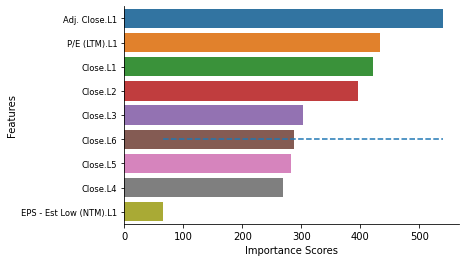

In [4]:
model_frufs_generated.feature_importance()

In [6]:
import logging

In [ ]:
# set up logging to console
console = logging.StreamHandler()
console.setLevel(logging.DEBUG)
# set a format which is simpler for console use
formatter = logging.Formatter('%(name)-12s: %(levelname)-8s %(message)s')
console.setFormatter(formatter)
# add the handler to the root logger
logging.getLogger('').addHandler(console)

logger = logging.getLogger(__name__)

In [16]:
logging.info("Error")